# Compute the charge-transfer resistance for real EIS data

In this tutorial, we show how to compute the charge-transfer resistance for real EIS data from a lithium-ion battery with a composite polymer electrolyte (see for more details on this battery: Z. Dai, J. Yu, J. Liu, R. Liu, Q. Sun, D. Chen, F. Ciucci, Highly conductive and nonflammable composite polymer electrolytes for rechargeable quasi-solid-state Li-metal batteries, J. Power Sources. 464 (2020) 228182). This tutorial illustrates the procedure described in: B. Py, A. Maradesa, and F. Ciucci. "Gaussian Processes for the Analysis of Electrochemical Impedance Spectroscopy Data: Prediction, Filtering, and Active Learning.", preprint (2022).

In [1]:
# import the libraries needed
import importlib
import GP_hilbert as gpf
importlib.reload(gpf)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

In [2]:
# plot standards
plt.rc('font', family='serif', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

## 1) Preliminary Work

### 1.1) Import the data

In [3]:
Z_data = pd.read_csv('./data/Li-ion.csv')
freq_vec, Z_exp = Z_data['freq'].values, Z_data['Real'].values+1j*Z_data['Imag'].values
omega_vec = 2.*np.pi*freq_vec
Z_exp = Z_exp
N_freqs = freq_vec.shape[0]

### 1.2) Define the ECM parameters

In [4]:
Rinf = 3.9647E-60
L = 2.51E-26

# parameters for one ZARC 
R1 = 979.0352
phi1 = 0.5
tau1 = 1.032
Z_exact1 = R1/(1+(1j*2.*np.pi*freq_vec*tau1)**phi1)

# parameters for a second ZARC
R2 = 1.4831E3
phi2 = 0.8168
tau2 = 0.000190600923910669
Z_exact2 = R2/(1+(1j*2.*np.pi*freq_vec*tau2)**phi2)

# parameters for a third ZARC
R3 = 314.5797
phi3 = 1.0
tau3 = 1.0539E-7 
Z_exact3 = R3/(1+(1j*2.*np.pi*freq_vec*tau3)**phi3) 

Z_ECM = Rinf + 1j*2.*np.pi*freq_vec*L + Z_exact1 + Z_exact2 + Z_exact3 # total impedance 

### 1.3) Draw the Nyquist plot 

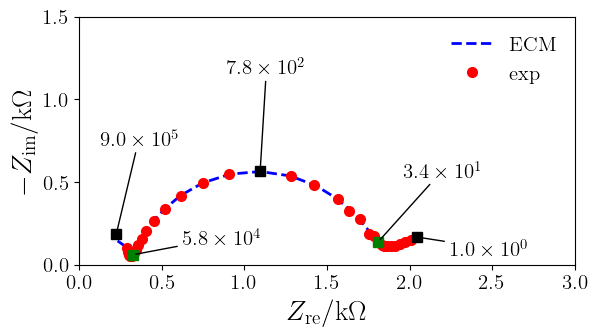

In [6]:
# Nyquist plot of the impedance
plt.plot(np.real(Z_ECM)/1000, -np.imag(Z_ECM)/1000, '--',linewidth = 2, color = 'blue', label = 'ECM')
plt.plot(np.real(Z_exp)/1000, -np.imag(Z_exp)/1000, 'o', markersize = 7, color = 'red', label = 'exp')
plt.plot(np.real(Z_exp[0]/1000), -np.imag(Z_exp[0]/1000), 's', markersize=7, color='black')
plt.plot(np.real(Z_exp[7]/1000), -np.imag(Z_exp[7]/1000), 's', markersize=7, color='green') # cut-off frequency at high freq.
plt.plot(np.real(Z_exp[18]/1000), -np.imag(Z_exp[18]/1000), 's', markersize=7, color='black')
plt.plot(np.real(Z_exp[26]/1000), -np.imag(Z_exp[26]/1000), 's', markersize=7, color='green') # cut-off frequency at low freq.
plt.plot(np.real(Z_exp[35]/1000), -np.imag(Z_exp[35]/1000), 's', markersize=7, color='black')

# label the frequencies
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec[0]/(10**(int(np.log10(freq_vec[0])))), int(np.log10(freq_vec[0]))), 
                 xy=(np.real(Z_exp[0])/1000, -np.imag(Z_exp[0])/1000), 
                 xytext=(np.real(Z_exp[0])/1000-100/1000, 550/1000-np.imag(Z_exp[0])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec[7]/(10**(int(np.log10(freq_vec[7])))), int(np.log10(freq_vec[7]))), 
                 xy=(np.real(Z_exp[7])/1000, -np.imag(Z_exp[7])/1000), 
                 xytext=(np.real(Z_exp[7])/1000+300/1000, 70/1000-np.imag(Z_exp[7])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec[18]/(10**(int(np.log10(freq_vec[18])))), int(np.log10(freq_vec[18]))), 
                 xy=(np.real(Z_exp[18])/1000, -np.imag(Z_exp[18])/1000), 
                 xytext=(np.real(Z_exp[18])/1000-200/1000, 600/1000-np.imag(Z_exp[18])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec[26]/(10**(int(np.log10(freq_vec[26])))), int(np.log10(freq_vec[26]))), 
                 xy=(np.real(Z_exp[26])/1000, -np.imag(Z_exp[26])/1000), 
                 xytext=(np.real(Z_exp[26])/1000+150/1000, 400/1000-np.imag(Z_exp[26])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec[35]/(10**(int(np.log10(freq_vec[35])))), int(np.log10(freq_vec[35]))), 
                 xy=(np.real(Z_exp[35])/1000, -np.imag(Z_exp[35])/1000), 
                 xytext=(np.real(Z_exp[35])/1000+200/1000, -100/1000-np.imag(Z_exp[35])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

# options of the plots
plt.legend(frameon=False, fontsize = 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 2.5)
plt.ylim(0, 1.25)
plt.xticks(np.arange(0, 3.001, 0.5))
plt.yticks(np.arange(0, 1.5001, 0.5))
plt.xlabel(r'$Z_{\rm re}/\rm k\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\rm k\Omega$', fontsize = 20)
plt.show()

## 2) GP regression

### 2.1) Truncate the range of EIS frequencies

In [7]:
freq_vec, Z_exp = np.array(Z_data[8:27].freq), np.array(Z_data[8:27].Real + 1j*Z_data[8:27].Imag)
N_freqs = len(freq_vec)
omega_vec = 2*np.pi*freq_vec

Z_exp_all = np.zeros(2*N_freqs) # bundle the real and imaginary parts of the impedance
Z_exp_all[:N_freqs], Z_exp_all[N_freqs:]=Z_exp.real, Z_exp.imag

### 2.2) Set the kernel options

In [8]:
ker_opts = {
    'sigma_DRT': 1.,
    'sigma_SB': 1.,
    'ell': 1.,
    'tau_max': 0.0008,
    'DRT': True,
    'SB': True,
    'SB_ker_type': 'IQ',
}

# these values are nominal

### 2.3) Initialize the hyperparameters 

In [9]:
sigma_n = 0.8
sigma_DRT = 11
sigma_SB = 1E-7
ell = 3
sigma_L = 0
sigma_R = 2

### 2.4) Minimize the negative marginal log-likelihood

In [10]:
theta_0 = np.array([sigma_n, sigma_DRT, sigma_SB, ell, sigma_R, sigma_L])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E, %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], gpf.NMLL_fct(theta, Z_exp_all, omega_vec, ker_opts, 're-im')))

res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp_all, omega_vec, ker_opts, 're-im'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})
res = minimize(gpf.NMLL_fct, abs(res.x), args=(Z_exp_all, omega_vec, ker_opts, 're-im'), method='Nelder-Mead', \
               callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

# collect the optimised hyperparameters
theta = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_R, sigma_L = theta

8.5221E+02, 5.4070E+04, -1.9638E-08, 5.6176E+00, 2.7253E+02, -4.910793E-11; evidence = 2.60008582E+02
-1.2153E+01, -4.0039E+04, 1.0181E-07, 5.5778E+00, -2.4286E+02, -4.129867E-11; evidence = 1.37300026E+02
-1.2031E+01, -4.4134E+04, 8.5197E-06, 8.1957E+00, -2.9302E+02, -9.638874E-12; evidence = 1.37216408E+02
-1.2026E+01, -4.4296E+04, 6.0136E-06, 1.0813E+01, -2.9292E+02, 1.098488E-11; evidence = 1.37216345E+02
Optimization terminated successfully.
         Current function value: 137.216345
         Iterations: 4
         Function evaluations: 578
1.2026E+01, 4.4296E+04, 6.0136E-06, 1.0813E+01, 2.9292E+02, 1.098488E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4296E+04, 6.0136E-06, 1.0813E+01, 2.9292E+02, 1.098488E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4296E+04, 6.0136E-06, 1.0813E+01, 2.9292E+02, 1.098488E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4296E+04, 6.0136E-06, 1.0813E+01, 2.9292E+02, 1.098488E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4296E+04, 6.0136E-06, 1.0813E+01,

1.2026E+01, 4.4307E+04, 6.0515E-06, 1.0998E+01, 2.9292E+02, 1.092835E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4307E+04, 6.0515E-06, 1.0998E+01, 2.9292E+02, 1.092835E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4307E+04, 6.0515E-06, 1.0998E+01, 2.9292E+02, 1.092835E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4307E+04, 6.0515E-06, 1.0998E+01, 2.9292E+02, 1.092835E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4307E+04, 6.0515E-06, 1.0998E+01, 2.9292E+02, 1.092835E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4307E+04, 6.0515E-06, 1.0998E+01, 2.9292E+02, 1.092835E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4307E+04, 6.0540E-06, 1.0999E+01, 2.9292E+02, 1.092246E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4307E+04, 6.0540E-06, 1.0999E+01, 2.9292E+02, 1.092246E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4307E+04, 6.0540E-06, 1.0999E+01, 2.9292E+02, 1.092246E-11; evidence = 1.37216345E+02
1.2026E+01, 4.4307E+04, 6.0540E-06, 1.0999E+01, 2.9292E+02, 1.092246E-11; evidence = 1.37216345E+02


In [11]:
# update the values of the kernel as the gpf functions simply copy ker_opts

ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT
tau_max = 0.0008

### 2.5) Recover the real and imaginary parts of the impedance 

In [12]:
# compute the blocks in the covariance matrix defined in equation (6c) of the main manuscript
K_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're')
K_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im')
K_re_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're-im')
K_im_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im-re')


# assemble the covariance matrix defined in equation (6c)
Sigma = sigma_n**2*np.eye(N_freqs)
K_full = np.zeros((2*N_freqs, 2*N_freqs))
K_full[:N_freqs, :N_freqs] = K_re + Sigma + (sigma_R**2)*np.ones(N_freqs)
K_full[:N_freqs, N_freqs:] = K_re_im
K_full[N_freqs:, :N_freqs] = K_im_re
K_full[N_freqs:, N_freqs:] = K_im + Sigma + (sigma_L**2)*np.outer(omega_vec, omega_vec)


# ensure the full covariance matrix is positive definite, and, if not, 
# replace it with its nearest positive definite matrix
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full) # nearest positive definite matrix
    

# compute the Cholesky factorisation of the full covariance matrix to evaluate its inverse
L = np.linalg.cholesky(K_full) # Cholesky factorisation of the full covariance matrix K_full
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L) # inverse of K_full


# frequency range for the GP regression
N_star_freqs = 200  
freq_star_vec = np.logspace(-2, 7, num=N_star_freqs, endpoint=True)
omega_star_vec = 2.*np.pi*freq_star_vec


mu_re_star_vec = np.zeros_like(omega_star_vec)
sigma_re_star_vec = np.zeros_like(omega_star_vec)

mu_im_star_vec = np.zeros_like(omega_star_vec)
sigma_im_star_vec = np.zeros_like(omega_star_vec)


for index, omega_star in enumerate(omega_star_vec):
    
    omega_star_np = np.array([omega_star])
    
    # k_star_star # equation (6a)
    k_star_star_re = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 're').flatten() + (sigma_R**2)
    k_star_star_im = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 'im').flatten() + (sigma_L**2)*omega_star_np**2
    
    # k_star # equation (6b)
    k_star_re_re = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're').flatten() + (sigma_R**2)*np.ones(N_freqs)
    k_star_re_im = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're-im').flatten()
    k_star_im_re = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im-re').flatten()
    k_star_im_im = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im').flatten() + (sigma_L**2)*omega_vec*omega_star_np

    # k_star_re
    k_star_re = np.zeros(2*N_freqs)
    k_star_re[:N_freqs] = k_star_re_re
    k_star_re[N_freqs:] = k_star_re_im
    
    # k_star_im
    k_star_im = np.zeros(2*N_freqs)
    k_star_im[:N_freqs] = k_star_im_re
    k_star_im[N_freqs:] = k_star_im_im
    
    mu_re_star_vec[index] = k_star_re@(inv_K_full@Z_exp_all) # equation (9a)
    sigma_re_star_vec[index] = np.sqrt(k_star_star_re - k_star_re@(inv_K_full@k_star_re)) # equation (9b)
    
    mu_im_star_vec[index] = k_star_im@(inv_K_full@Z_exp_all) # equation (9a)
    sigma_im_star_vec[index] = np.sqrt(k_star_star_im - k_star_im@(inv_K_full@k_star_im)) # equation (9b)

### 2.6) Draw the Nyquist plot

In [13]:
# complete frequency range 
Z_data0 = pd.read_csv('./EIS_BatteryLi.csv')
freq_vec0, Z_exp0 = Z_data0['freq'].values, Z_data0['Real'].values + 1j*Z_data0['Imag'].values
omega_vec0 = 2.*np.pi*freq_vec0
Z_exp0 = Z_exp0
N_freqs0 = freq_vec0.shape[0]

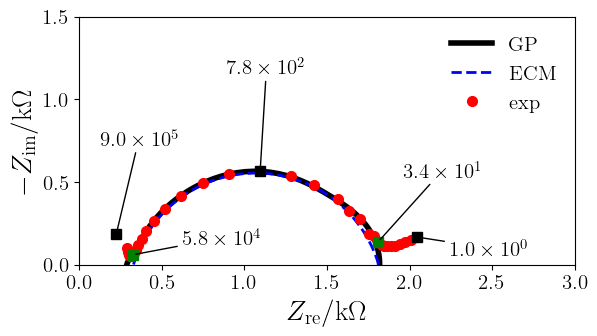

In [15]:
# ECM to approximately evaluate the Rp
Z_ECM_Rp = 330 + R2/(1+(1j*2.*np.pi*freq_star_vec*tau2)**phi2)  

# Nyquist plot of the impedances
plt.plot(mu_re_star_vec/1000, -mu_im_star_vec/1000, linewidth=4, color='black', label='GP')
plt.plot(np.real(Z_ECM_Rp)/1000, -np.imag(Z_ECM_Rp)/1000, '--',linewidth=2, color='blue', label='ECM')
plt.plot(np.real(Z_exp0)/1000, -np.imag(Z_exp0)/1000, 'o', markersize=7, color='red', label='exp')
plt.plot(np.real(Z_exp0[0])/1000, -np.imag(Z_exp0[0])/1000, 's', markersize=7, color='black')
plt.plot(np.real(Z_exp0[7])/1000, -np.imag(Z_exp0[7])/1000, 's', markersize=7, color='green') # cut-off frequency at high freq.
plt.plot(np.real(Z_exp0[18])/1000, -np.imag(Z_exp0[18])/1000, 's', markersize=7, color='black')
plt.plot(np.real(Z_exp0[26])/1000, -np.imag(Z_exp0[26])/1000, 's', markersize=7, color='green') # cut-off frequency at low freq.
plt.plot(np.real(Z_exp0[35])/1000, -np.imag(Z_exp0[35])/1000, 's', markersize=7, color='black')

# label the frequencies
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec0[0]/(10**(int(np.log10(freq_vec0[0])))), int(np.log10(freq_vec0[0]))), 
                 xy=(np.real(Z_exp0[0])/1000, -np.imag(Z_exp0[0])/1000), 
                 xytext=(np.real(Z_exp0[0])/1000-100/1000, 550/1000-np.imag(Z_exp0[0])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec0[7]/(10**(int(np.log10(freq_vec0[7])))), int(np.log10(freq_vec0[7]))), 
                 xy=(np.real(Z_exp0[7])/1000, -np.imag(Z_exp0[7])/1000), 
                 xytext=(np.real(Z_exp0[7])/1000+300/1000, 70/1000-np.imag(Z_exp0[7])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec0[18]/(10**(int(np.log10(freq_vec0[18])))), int(np.log10(freq_vec0[18]))), 
                 xy=(np.real(Z_exp0[18])/1000, -np.imag(Z_exp0[18])/1000), 
                 xytext=(np.real(Z_exp0[18])/1000-200/1000, 600/1000-np.imag(Z_exp0[18])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec0[26]/(10**(int(np.log10(freq_vec0[26])))), int(np.log10(freq_vec0[26]))), 
                 xy=(np.real(Z_exp0[26])/1000, -np.imag(Z_exp0[26])/1000), 
                 xytext=(np.real(Z_exp0[26])/1000+150/1000, 400/1000-np.imag(Z_exp0[26])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'${0:.1f}\times 10^{1}$'.format(freq_vec0[35]/(10**(int(np.log10(freq_vec0[35])))), int(np.log10(freq_vec0[35]))), 
                 xy=(np.real(Z_exp0[35])/1000, -np.imag(Z_exp0[35])/1000), 
                 xytext=(np.real(Z_exp0[35])/1000+200/1000, -100/1000-np.imag(Z_exp0[35])/1000), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

# options of the plots
plt.legend(frameon=False, fontsize = 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 2.5)
plt.ylim(0, 1.25)
plt.xticks(np.arange(0, 3.001, 0.5))
plt.yticks(np.arange(0, 1.5001, 0.5))
plt.xlabel(r'$Z_{\rm re}/\rm k\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\rm k\Omega$', fontsize = 20)
plt.show()

## 3) Evaluate the charge-transfer resistance as a stochastic variable

We recall that 

$$ 
\begin{pmatrix}
Z_{\rm re}(\omega \rightarrow 0) \\
Z_{\rm re}(\omega \rightarrow \infty) \end{pmatrix} | \; \mathbf Z = \mathbf Z_{\rm exp}
\sim \mathcal{N} \left(\bf \mu_{\rm re}(0,\infty), \mathbf \Sigma_{\rm re}(0,\infty) \right) 
$$

where 

$$
\mu_{\rm re}(0,\infty) = \begin{pmatrix}
\mu^{0}_{\rm re} \\
\mu^{\infty}_{\rm re} \end{pmatrix} = \mathbf K_{\rm re,im}(0,\infty) \mathbf K^{-1}(\bf \omega,\bf \omega) \mathbf Z_{\rm exp}
$$

$$ 
\Sigma_{\rm re}(0,\infty) = \begin{pmatrix}
\Sigma^{0}_{\rm re} & \Sigma^{0,\infty}_{\rm re} \\
\Sigma^{0,\infty}_{\rm re} & \Sigma^{\infty}_{\rm re} \end{pmatrix} = \mathbf K_{\rm re}(0,\infty) - \mathbf K_{\rm re,im}(0,\infty) \mathbf K^{-1}(\omega,\omega) \mathbf K^\top_{\rm re,im}(0,\infty) 
$$

The charge-transfer resistance $ R_{\rm ct} = Z_{\rm re}(0) - Z_{\rm re}(\infty)$ is the following Gaussian random variable

$$
R_{\rm ct} \sim \mathcal{N} \left(\mu_{R_{\rm ct}}, \mathbf \sigma^{2}_{R_{\rm ct}} \right) 
$$

where

$$
\mu_{R_{\rm ct}} = \mu^{0}_{\rm re} - \mu^{\infty}_{\rm re}
$$

$$
\sigma_{R_{\rm ct}} = \sqrt{\Sigma^{0}_{\rm re} - 2\Sigma^{0,\infty}_{\rm re} + \Sigma^{\infty}_{\rm re}}
$$

In [19]:
K_re_0inf = np.zeros((2,2)) # equation (15a)
K_re_0inf[0,0] = tau_max*sigma_DRT**2 + sigma_R**2 + 2*sigma_SB**2 
K_re_0inf[0,1] = sigma_R**2
K_re_0inf[1,0] = sigma_R**2
K_re_0inf[1,1] = sigma_R**2 + sigma_SB**2 

K_reim_0inf = np.zeros((2, 2*N_freqs)) # equation (15b)
for i in range(N_freqs):
    K_reim_0inf[0,i] = np.arctan(tau_max*omega_vec[i])*sigma_DRT**2/omega_vec[i] + sigma_R**2 
    + gpf.k_SB(0,omega_vec[i], ker_opts, 're') 
    K_reim_0inf[0,i+N_freqs] = -np.log(1 + omega_vec[i]**2*tau_max**2)*sigma_DRT**2/(2*omega_vec[i]) - gpf.k_SB(0,omega_vec[i], ker_opts, 're-im') 
    K_reim_0inf[1,i] = sigma_R**2

# Mean of the charge-transfer resistance considered as a Gaussian random variable
mu_re_0inf = np.dot(K_reim_0inf, np.dot(inv_K_full, Z_exp_all)) # equation (17a)
mean_Rct = mu_re_0inf[0] - mu_re_0inf[1] # equation (18)
print('stochastic Rct', mean_Rct, 'Ohm') # comparison with the experimental value of R_ct
print('ECM Rct', np.real(Z_ECM_Rp[0] - Z_ECM_Rp[len(freq_star_vec)-1]), 'Ohm')

# Standard deviation of the charge-transfer resistance considered as a Gaussian random variable
sigma_re_0inf = K_re_0inf - np.dot(K_reim_0inf, np.dot(inv_K_full, np.transpose(K_reim_0inf))) # equation (17b)
if not gpf.is_PD(sigma_re_0inf): # replace sigma_re_0inf with its nearest positive definite matrix if not positive definite
    sigma_re_0inf = gpf.nearest_PD(sigma_re_0inf)
std_Rct = np.sqrt(sigma_re_0inf[0,0] - 2*sigma_re_0inf[0,1] + sigma_re_0inf[1,1]) # equation (18)
print('std_Rct', std_Rct, 'Ohm')

stochastic Rct 1529.366611279761 Ohm
ECM Rct 1482.8631670666334 Ohm
std_Rct 43.72030736767328 Ohm
